# Subgrid Emulator - Basic Usage Examples

This notebook demonstrates how to use the `subgrid_emu` package to make predictions for various cosmological summary statistics.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from subgrid_emu import (
    load_emulator, 
    list_available_statistics,
    get_x_grid,
    get_plot_info,
    get_parameter_info
)

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

## 1. List Available Statistics

In [2]:
stats = list_available_statistics()
print("5-parameter models:")
for stat in stats['5-parameter']:
    print(f"  - {stat}")
    
print("\n2-parameter models:")
for stat in stats['2-parameter']:
    print(f"  - {stat}")

5-parameter models:
  - GSMF
  - BHMSM
  - fGas
  - CGD
  - CGED
  - Pk
  - CSFR

2-parameter models:
  - CGD_2p
  - CGD_CC_2p
  - fGas_2p


## 2. Parameter Information

In [3]:
param_info = get_parameter_info()

print("Input Parameters:")
print("=" * 80)
for i, name in enumerate(param_info['names']):
    latex_name = param_info['latex_names'][i]
    range_val = param_info['ranges'][name]
    desc = param_info['descriptions'][name]
    print(f"{i+1}. {name} ({latex_name})")
    print(f"   Range: {range_val}")
    print(f"   Description: {desc}")
    print()

Input Parameters:
1. kappa_w ($\kappa_\text{w}$)
   Range: (2.0, 4.0)
   Description: Wind efficiency parameter

2. e_w ($e_\text{w}$)
   Range: (0.2, 1.0)
   Description: Wind energy fraction

3. M_seed ($M_\text{seed}/10^{6}$)
   Range: (0.6, 1.2)
   Description: Black hole seed mass (in 10^6 M_sun)

4. v_kin ($v_\text{kin}/10^{4}$)
   Range: (0.1, 1.2)
   Description: Kinetic wind velocity (in 10^4 km/s)

5. epsilon_kin ($\epsilon_\text{kin}/10^{1}$)
   Range: (0.02, 1.2)
   Description: Kinetic feedback efficiency (in 10^1)



## 3. Single Prediction Example - Galaxy Stellar Mass Function

SubgridEmulator(stat_name='GSMF', z_index=0, n_params=5)


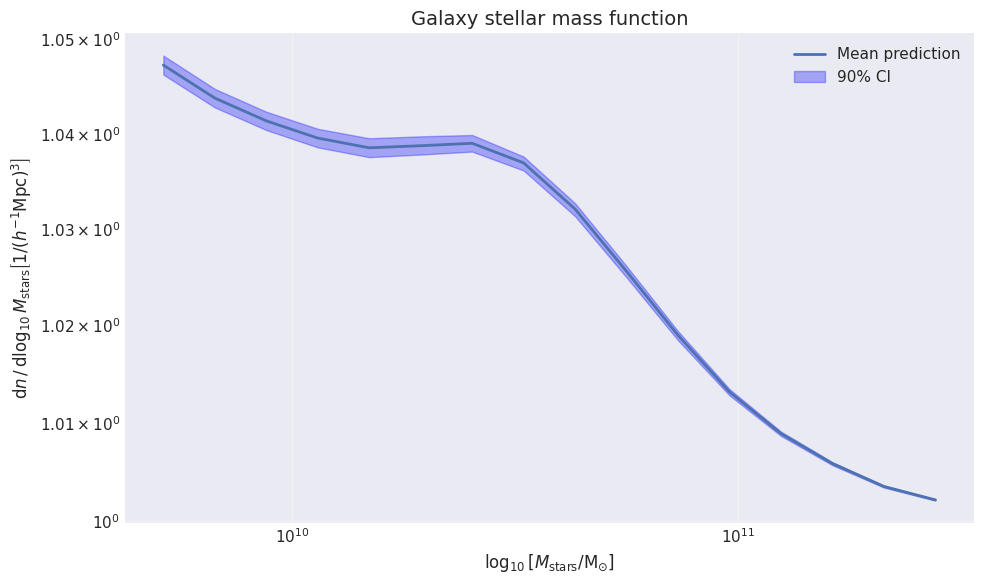

Prediction shape: (16,)
X-grid shape: (16,)


In [4]:
# Load the GSMF emulator
emu_gsmf = load_emulator('GSMF')
print(emu_gsmf)

# Define parameters: [kappa_w, e_w, M_seed/1e6, v_kin/1e4, eps/1e1]
params = np.array([3.0, 0.5, 0.8, 0.65, 0.1])

# Make prediction
mean, quantiles = emu_gsmf.predict(params)

# Get x-grid and plot info
x_grid, x_label = get_x_grid('GSMF')
plot_info = get_plot_info('GSMF')

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(x_grid, mean, 'b-', lw=2, label='Mean prediction')
ax.fill_between(x_grid, quantiles[:, 0], quantiles[:, 1], 
                alpha=0.3, color='blue', label='90% CI')
ax.set_xscale(plot_info['xscale'])
ax.set_yscale(plot_info['yscale'])
ax.set_xlabel(plot_info['xlabel'], fontsize=12)
ax.set_ylabel(plot_info['ylabel'], fontsize=12)
ax.set_title(plot_info['title'], fontsize=14)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Prediction shape: {mean.shape}")
print(f"X-grid shape: {x_grid.shape}")

## 4. Multiple Statistics Comparison

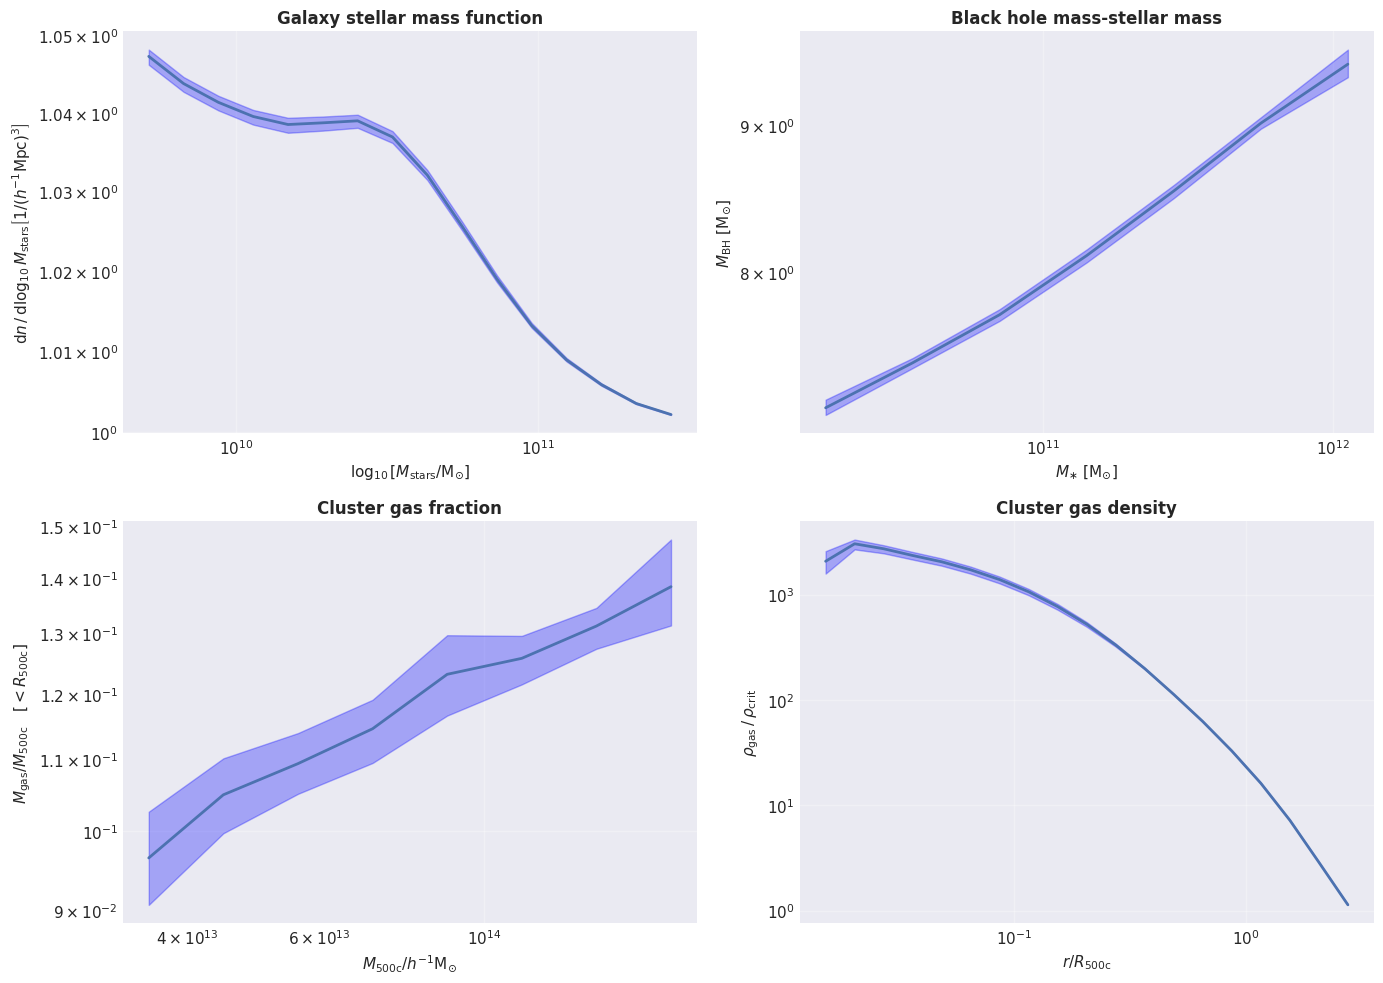

In [5]:
# Define parameters
params = np.array([3.0, 0.5, 0.8, 0.65, 0.1])

# Statistics to plot
stats_to_plot = ['GSMF', 'BHMSM', 'fGas', 'CGD']

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, stat_name in enumerate(stats_to_plot):
    # Load emulator
    emu = load_emulator(stat_name)
    
    # Make prediction
    mean, quantiles = emu.predict(params)
    
    # Get plotting info
    x_grid, _ = get_x_grid(stat_name)
    plot_info = get_plot_info(stat_name)
    
    # Plot
    ax = axes[i]
    ax.plot(x_grid, mean, 'b-', lw=2)
    ax.fill_between(x_grid, quantiles[:, 0], quantiles[:, 1], 
                    alpha=0.3, color='blue')
    ax.set_xscale(plot_info['xscale'])
    ax.set_yscale(plot_info['yscale'])
    ax.set_xlabel(plot_info['xlabel'], fontsize=11)
    ax.set_ylabel(plot_info['ylabel'], fontsize=11)
    ax.set_title(plot_info['title'], fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Parameter Variation Study

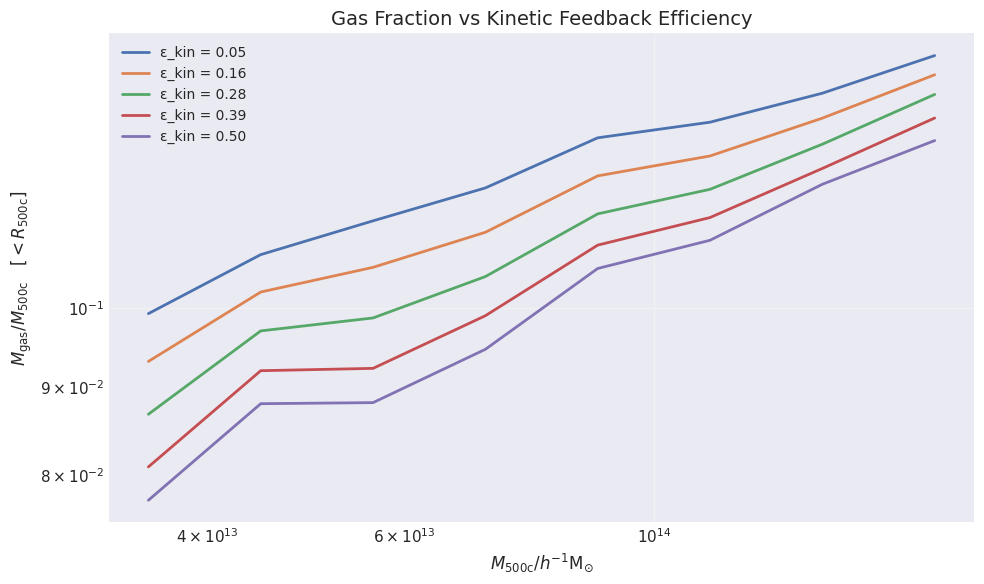

In [6]:
# Load emulator for gas fraction
emu_fgas = load_emulator('fGas')

# Base parameters
base_params = np.array([3.0, 0.5, 0.8, 0.65, 0.1])

# Vary the last parameter (epsilon_kin)
eps_values = np.linspace(0.05, 0.5, 5)

# Get x-grid
x_grid, _ = get_x_grid('fGas')
plot_info = get_plot_info('fGas')

# Plot
fig, ax = plt.subplots(figsize=(10, 6))

for eps in eps_values:
    params = base_params.copy()
    params[4] = eps
    
    mean, _ = emu_fgas.predict(params)
    
    ax.plot(x_grid, mean, lw=2, label=f'ε_kin = {eps:.2f}')

ax.set_xscale(plot_info['xscale'])
ax.set_yscale(plot_info['yscale'])
ax.set_xlabel(plot_info['xlabel'], fontsize=12)
ax.set_ylabel(plot_info['ylabel'], fontsize=12)
ax.set_title('Gas Fraction vs Kinetic Feedback Efficiency', fontsize=14)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Using 2-Parameter Models

In [9]:
# Load 2-parameter model for CGD
emu_cgd_2p = load_emulator('CGD_2p')
print(emu_cgd_2p)

# Only need 2 parameters: [v_kin/1e4, eps/1e1]
params_2p = np.array([0.65, 0.1])

# Make prediction
mean, quantiles = emu_cgd_2p.predict(params_2p)

# Get plotting info
x_grid, _ = get_x_grid('CGD_2p')
plot_info = get_plot_info('CGD_2p')

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(x_grid, mean, 'r-', lw=2, label='2-param model')
ax.fill_between(x_grid, quantiles[:, 0], quantiles[:, 1], 
                alpha=0.3, color='red', label='90% CI')
ax.set_xscale(plot_info['xscale'])
ax.set_yscale(plot_info['yscale'])
ax.set_xlabel(plot_info['xlabel'], fontsize=12)
ax.set_ylabel(plot_info['ylabel'], fontsize=12)
ax.set_title('Cluster Gas Density (2-parameter model)', fontsize=14)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

IndexError: index 2 is out of bounds for axis 1 with size 2

## 7. Batch Predictions

Parameter samples:
[[2.74908024 0.96057145 1.03919637 0.75852433 0.09488895]
 [2.31198904 0.24646689 1.11970569 0.76122651 0.35987484]
 [2.04116899 0.97592788 1.09946558 0.33357302 0.10727598]
 [2.36680902 0.44339379 0.91485386 0.57513952 0.15978999]
 [3.22370579 0.31159509 0.77528679 0.50299803 0.23891359]]



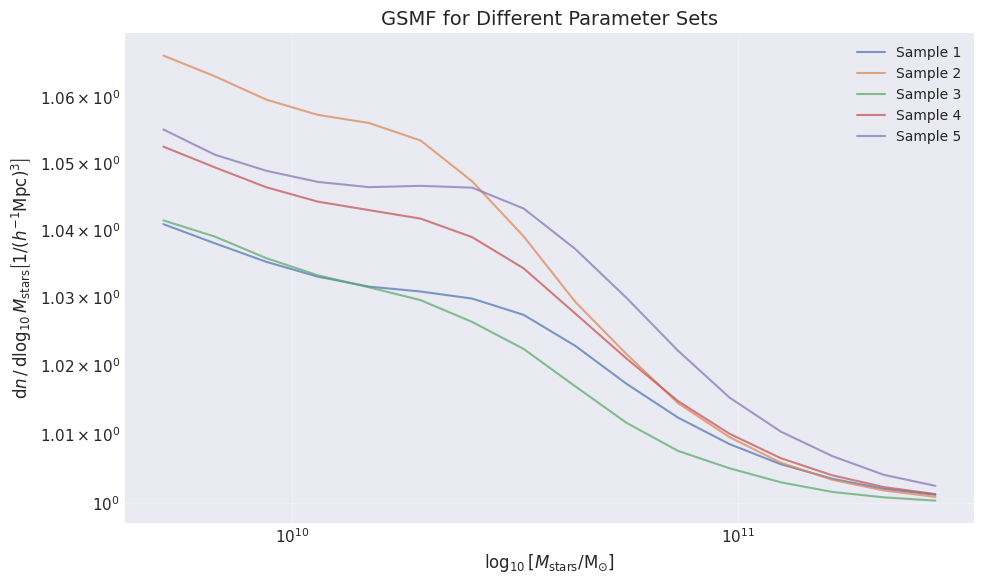

In [8]:
# Load emulator
emu = load_emulator('GSMF')

# Create random parameter samples
np.random.seed(42)
n_samples = 5
params_batch = np.random.uniform(
    low=[2.0, 0.2, 0.6, 0.1, 0.02],
    high=[4.0, 1.0, 1.2, 1.2, 0.5],
    size=(n_samples, 5)
)

print("Parameter samples:")
print(params_batch)
print()

# Make predictions
x_grid, _ = get_x_grid('GSMF')
plot_info = get_plot_info('GSMF')

fig, ax = plt.subplots(figsize=(10, 6))

for i, params in enumerate(params_batch):
    mean, _ = emu.predict(params)
    ax.plot(x_grid, mean, lw=1.5, alpha=0.7, label=f'Sample {i+1}')

ax.set_xscale(plot_info['xscale'])
ax.set_yscale(plot_info['yscale'])
ax.set_xlabel(plot_info['xlabel'], fontsize=12)
ax.set_ylabel(plot_info['ylabel'], fontsize=12)
ax.set_title('GSMF for Different Parameter Sets', fontsize=14)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Summary

This notebook demonstrated:
1. How to list available statistics
2. How to get parameter information
3. How to make single predictions
4. How to compare multiple statistics
5. How to study parameter variations
6. How to use 2-parameter models
7. How to make batch predictions

For more information, see the package documentation in the README.